In [2]:
#libraries and data
import pandas as pd
import matplotlib.pyplot as plt
import requests as req

In [ ]:
#Classes to process the data
class State(object):
  def __init__(self, state, new_cases_per_100k, dem_margin):
    self.state = state
    self.cases = new_cases_per_100k
    self.dem_margin = dem_margin 

In [22]:
#Covid Data 
cov_key = "2c3b686a09214915b1471a2f0df00d20"
cov_url = "https://api.covidactnow.org/v2/states.json?apiKey="+cov_key

#Get data
cov_data = req.get(cov_url).json()

#Create dataframe
df = pd.DataFrame(cov_data)
state_covid_data = []

for row in df.iterrows():
  state_covid_data.append({row[1].state: row[1].metrics["weeklyNewCasesPer100k"]})

print(state_covid_data)

63.7
182.0
95.2
101.3
114.0
59.6
137.0
64.5
101.3
188.0
137.7
93.3
69.8
52.4
77.9
103.0
80.2
171.8
147.3
162.4
122.3
99.2
98.8
62.0
90.2
None
194.1
72.0
215.7
66.8
72.7
114.4
209.1
75.2
66.8
187.4
87.2
142.5
59.3
119.0
235.4
222.1
244.9
59.1
163.1
123.9
61.0
151.6
74.2
73.5
93.9
119.9
40.4
[{'AK': 63.7}, {'AL': 182.0}, {'AR': 95.2}, {'AZ': 101.3}, {'CA': 114.0}, {'CO': 59.6}, {'CT': 137.0}, {'DC': 64.5}, {'DE': 101.3}, {'FL': 188.0}, {'GA': 137.7}, {'HI': 93.3}, {'IA': 69.8}, {'ID': 52.4}, {'IL': 77.9}, {'IN': 103.0}, {'KS': 80.2}, {'KY': 171.8}, {'LA': 147.3}, {'MA': 162.4}, {'MD': 122.3}, {'ME': 99.2}, {'MI': 98.8}, {'MN': 62.0}, {'MO': 90.2}, {'MP': None}, {'MS': 194.1}, {'MT': 72.0}, {'NC': 215.7}, {'ND': 66.8}, {'NE': 72.7}, {'NH': 114.4}, {'NJ': 209.1}, {'NM': 75.2}, {'NV': 66.8}, {'NY': 187.4}, {'OH': 87.2}, {'OK': 142.5}, {'OR': 59.3}, {'PA': 119.0}, {'PR': 235.4}, {'RI': 222.1}, {'SC': 244.9}, {'SD': 59.1}, {'TN': 163.1}, {'TX': 123.9}, {'UT': 61.0}, {'VA': 151.6}, {'VT': 74.2

In [4]:
#Voting Data 
vote_data = pd.read_csv(r'../data/pop_vote2.csv')

#Make a dictionary with the states as keys and the democratic margin as values
vote_dict = dict(zip(vote_data['state'], vote_data['dem_this_margin']))

print(vote_dict)

#Dict of abbreviations and full names
state_dict = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}

def get_color(dem_margin):
    margin_num = float(dem_margin[:-1])
    if margin_num > 0:
        return 'blue'
    else:
        return 'red'

def get_alpha(dem_margin):
    margin_num = float(dem_margin[:-1])
    if margin_num > 0:
        return margin_num/45
    else:
        return -margin_num/45

{'Arizona': '0.3%', 'Florida': '-3.4%', 'Georgia': '0.2%', 'Iowa': '-8.2%', 'Michigan': '2.8%', 'Minnesota': '7.1%', 'Nevada': '2.4%', 'New Hampshire': '7.4%', 'North Carolina': '-1.3%', 'Ohio': '-8.0%', 'Pennsylvania': '1.2%', 'Texas': '-5.6%', 'Wisconsin': '0.6%', 'Non-Battlegrounds': nan, 'Alabama': '-25.5%', 'Alaska': '-10.1%', 'Arkansas': '-27.6%', 'California': '29.2%', 'Colorado': '13.5%', 'Connecticut': '20.1%', 'Delaware': '19.0%', 'District of Columbia': '86.8%', 'Hawaii': '29.5%', 'Idaho': '-30.8%', 'Illinois': '17.0%', 'Indiana': '-16.1%', 'Kansas': '-14.7%', 'Kentucky': '-25.9%', 'Louisiana': '-18.6%', 'Maine': '9.1%', 'Maryland': '33.2%', 'Massachusetts': '33.5%', 'Mississippi': '-16.5%', 'Missouri': '-15.4%', 'Montana': '-16.4%', 'Nebraska': '-19.2%', 'New Jersey': '15.9%', 'New Mexico': '10.8%', 'New York': '23.1%', 'North Dakota': '-33.4%', 'Oklahoma': '-33.1%', 'Oregon': '16.1%', 'Rhode Island': '20.8%', 'South Carolina': '-11.7%', 'South Dakota': '-26.2%', 'Tennessee

[0.413650561482889, 0.325009968010589, 0.3285041043089611, 0.3284306835943752, 0.3018488228313552, 0.30248339218884146, 0.26858539018036975, 0.24798334818752843, 0.3328701820975103, 0.3420428790984823, 0.27544452170738604, 0.2583559813316458, 0.28236140561065204, 0.2874993355026258, 0.3154934874790293, 0.29969048838131973, 0.31656113965058347, 0.3742039759848136, 0.3286985829012858, 0.31599942720373136, 0.22054905320824125, 0.22988189362987385, 0.3003040896650468, 0.3094359702902601, 0.2860773275059194, 0.2206697136461151, 0.32287462758081, 0.30399203576420925, 0.3220679773350404, 0.3688571271103926, 0.28921613227406007, 0.27279620448757125, 0.33409587050040584, 0.31585837471725164, 0.28577611004117975, 0.34121696279668284, 0.28502202906981716, 0.31875644274370474, 0.22396417794660975, 0.269262143562223, 0.34458905580810184, 0.4253120513215042, 0.3480350627360541, 0.30846913895636624, 0.34993265657017963, 0.2810735083372704, 0.33665880838114537, 0.26189432651957073, 0.23926383317654637

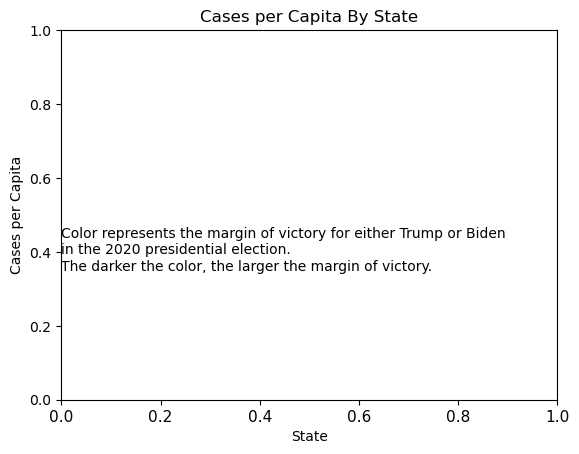

In [5]:
#Create a bar chart with the number of deaths per state

cases = []

#Get an array of deaths by state
for i in range(len(df)):
    cases.append(df['actuals'][i]['cases'])

#Create an array of population by state
pop = []
for i in range(len(df)):
    pop.append(df['population'][i])

#Deaths per captia
cases_per_capita = []
for i in range(len(df)):
    cases_per_capita.append(cases[i]/pop[i])

print(cases_per_capita)

#Create a dictionary of states and deaths per captia
states = df['state'].to_list()
states_vs_deaths = dict(zip(states, cases_per_capita))

#Sort the dictionary
states_vs_deaths = {k: v for k, v in sorted(states_vs_deaths.items(), key=lambda item: item[1])}

#Create a bar chart
plt.figure(0)

for key, value in vote_dict.items():
    try:
        state_name = state_dict[key]
        state_percent = vote_dict[state_name]
        plt.scatter(state_percent, value, color='white', edgecolor='black')
    except KeyError:
        pass

plt.rcParams["figure.figsize"] = [20.50, 4.50]
plt.tick_params(axis='x', which='major', labelsize=11)
plt.rcParams["figure.autolayout"] = True
plt.title('Cases per Capita By State')
plt.xlabel('State')
plt.ylabel('Cases per Capita')
plt.text(0, .35, 'Color represents the margin of victory for either Trump or Biden \nin the 2020 presidential election. \nThe darker the color, the larger the margin of victory.')
plt.show()


In [6]:
#Calculate the average COVID rates for red and blue states
red_states = []
blue_states = []

for key, value in states_vs_deaths.items():
    try:
        state_name = state_dict[key]
        if vote_dict[state_name][:-1] > '0':
            blue_states.append(value)
        else:
            red_states.append(value)
    except KeyError:
        pass

cov_red = sum(red_states)/len(red_states)
cov_blue = sum(blue_states)/len(blue_states)

print('Average COVID rate for red states: ' + str(cov_red * 100)+'%')
print('Average COVID rate for blue states: ' + str(cov_blue * 100)+'%')
print('Difference in COVID rates: ' + str((cov_red-cov_blue)*100)+ '%')


Average COVID rate for red states: 32.35042006725739%
Average COVID rate for blue states: 29.266635829562237%
Difference in COVID rates: 3.083784237695153%
